# H3 Deidentification using Python
*Melissa Pearson, 10/24/2025*  

Update: 11/11/2025.  
* Add layer of resolution and outer boundary geometry of cell set.
* Make function definition terminology more abstract

This notebook follows the same basic forumlas as the observable notebook, just using python libraries.

## Import Pyhon libraries
* pandas: data manipulation
* h3: h3 geospatial conversions
* folium: mapping

In [1]:
import pandas as pd
import geopandas as gpd
import h3

In [72]:
# Utility to convert H3 shapes for storage
from shapely.geometry import Polygon, MultiPolygon
from h3 import LatLngPoly

def latlngpoly_to_shapely(latlngpoly: LatLngPoly):
    # Outer boundary
    outer = [(lng, lat) for lat, lng in latlngpoly.outer]
    # Holes (if any)
    holes = [[(lng, lat) for lat, lng in hole] for hole in latlngpoly.holes]
    return Polygon(outer, holes)

def get_boundary_geometry(latlngpoly: LatLngPoly):
    # Outer boundary
    outer = latlngpoly.outer
    return outer

    

def cellset_to_shapely(cell_set):
    cell_set_latlngpoly = h3.cells_to_h3shape(cell_set)
    # coords = [(coord[1],coord[0]) for coord in cell_set_latlngpoly.outer]
    coords = tuple(coord[::-1] for coord in cell_set_latlngpoly.outer)
    return Polygon(coords)
    

In [73]:
cell_set = ['88489c0247fffff']
print(cellset_to_shapely(cell_set))

POLYGON ((-98.56571993695822 29.473125875131014, -98.57098811082018 29.47548518637805, -98.57589242114467 29.472683906730335, -98.57552824955025 29.467523412534533, -98.57026022652587 29.465164300011487, -98.56535622425596 29.46796548297661, -98.56571993695822 29.473125875131014))


## Load data
Previous work extracted the Texas population data from the kontur population dataset and downloaded a list of texas school data that was condensed to reduce the number of columns.  Here this data is loaded from csv files stored locally. 

In [99]:
schools=pd.read_csv('tx_schools_condensed.csv', index_col=0)
pop = pd.read_csv('txpop_h3.csv', index_col=0)

In [100]:
schools.head()

Long        Lat                                    LongLabel  \
0 -97.366710  30.988880  Little River, Little River-Academy, TX, USA   
1 -95.436392  29.957201     11902 Spears Rd, Houston, TX, 77067, USA   
2 -97.401400  30.879140                             Holland, TX, USA   
3 -97.222274  31.397236   1191 Old Lorena Rd, Lorena, TX, 76655, USA   
4 -94.615940  33.508480                             De Kalb, TX, USA   

          School_Nam       County_Nam                  City        Subregion  
0      ACADEMY JJAEP      BELL COUNTY  Little River-Academy      Bell County  
1     FORTIS ACADEMY    HARRIS COUNTY               Houston    Harris County  
2  BELL COUNTY JJAEP      BELL COUNTY               Holland      Bell County  
3         LORENA PRI  MCLENNAN COUNTY                Lorena  McLennan County  
4    NEW BOSTON DAEP     BOWIE COUNTY               De Kalb     Bowie County

In [101]:
schools_points = schools.drop_duplicates(subset=['Long', 'Lat'], keep='first')

## Rewrite Observable function into python
Observable Anonymization function
```
outputCellValues = {
  const outputCells = new Map();

  function getAnonymizingSum(cells) {
    return cells.map(cell => popMapSchools.get(cell) ?? 0).reduce((sum, val) => sum + val, 0);
  }
  
  for (const {lat, lng} of schoolLocations) {
    // Get the set of cells at the target res that have an anonymizing value over the threshold
    let currentRes = h3Resolution;
    let candidateSet = [h3.latLngToCell(lat, lng, currentRes)];
    while (getAnonymizingSum(candidateSet) < populationThreshold && currentRes > 3) {
      currentRes--;
      const parentCell = h3.latLngToCell(lat, lng, currentRes);
      candidateSet = h3.cellToChildren(parentCell, h3Resolution);
    }
    // Add all cells to the output map
    for (const cell of candidateSet) {
      const currentValue = outputCells.get(cell) ?? 0;
      outputCells.set(cell, currentValue + (1 / candidateSet.length))
    }
  }

  return outputCells;
}
```

Analysis of Steps:

1. Function getAnonymizingSum takes in a list of H3 Cells.  It references the TX H3 population values for those cells and sums the list, using 0 if the value of the cell is null or undefined.  ('??' is the [Nullish Coalescing Pperator](https://www.w3schools.com/jsref/jsref_oper_nullish.asp))
2. **OUTER LOOP** Loop through all the points in the list of data points (here: school locations)
    1. Specify h3 resolution to use
    2. Initiate candidate set list of h3 cells with the one containing the point at the specified resolution
3. **INNER LOOP #1**
    1. While loop conditioned on the sum of the populations in the candidate set list (initiated to a list of length 1 with the pop of the initial cell) being less than the anonymizing threshold specified (this is specified outside the function - likely should be a function initial parameter) and a resolution  > 3
    2. Take current resolution and go down a level (i.e. start at 8 and first loop is at 7.
    3. Get the parent cell of your res8 cell at res 7
    4. Get ALL children of the parent cell down to the original resolution
4. **INNER LOOP #2**
    1. Once sum of candidate cells is over threshold, divide the metric value over the full candidate set
  

## Conversion to Python function

In [102]:
def cellset_to_shapely(cell_set):
    cell_set_latlngpoly = h3.cells_to_h3shape(cell_set)
    # coords = [(coord[1],coord[0]) for coord in cell_set_latlngpoly.outer]
    coords = tuple(coord[::-1] for coord in cell_set_latlngpoly.outer)
    return Polygon(coords)
    
def get_output_cell_values(point_location_dataframe, h3_threshold_dataframe, h3_resolution, h3_threshold, latitude_col='lat',longitude_col='lng', threshold_col= 'population'):
    """
    Calculate output cell values with anonymizing aggregation.
    
    Args:
        point_location_dataframe: DataFrame with 'Lat' and 'Long' columns
        h3_threshold_dataframe: DataFrame H3 cells to metric used to evaluate the threshold, for Kontur data this is population. the h3 column should be labeled 'h3'
        h3_resolution: Target H3 resolution, for Kontur data this is level 8 as that is the resolution of the dataset
        h3_threshold: Minimum threshold value from the h3_threshold_dataframe for anonymization
        latitude_col: name of the latitude column in the point_location_dataframe.  Default value is 'lat'
        longitude_col: name of the longitude column in the point_location_dataframe.  Default value is 'lng'
        threshold_col: name of the column in the h3_threshold_dataframe for the value used in thresholding. For kontur date this is 'population'
    
    Returns:
        Dict mapping H3 cells to aggregated values
    """
    import h3
    
    # Convert pop_map_schools DataFrame to dict for faster lookups
    threshold_dict = h3_threshold_dataframe.set_index('h3')[threshold_col].to_dict()
        
    output_cells_dict = {}
    
    def get_anonymizing_sum(cells):
        return sum(threshold_dict.get(cell, 0) for cell in cells)
    
    results = []
    
    for _, row in point_location_dataframe.iterrows():
        lat, lng = row[latitude_col], row[longitude_col]
        
        # Get the set of cells at the target res that have an anonymizing value over the threshold
        current_res = h3_resolution        
        candidate_set = [h3.latlng_to_cell(lat, lng, current_res)]
        
        while get_anonymizing_sum(candidate_set) < h3_threshold and current_res > 3:
            current_res -= 1
            parent_cell = h3.latlng_to_cell(lat, lng, current_res)
            candidate_set = list(h3.cell_to_children(parent_cell, h3_resolution))
        
        # generate boundary of candidate cells and translate into a shapely object
        candidate_set_boundary = h3.cells_to_h3shape(candidate_set, tight=True)
        # boundary_geometry = latlngpoly_to_shapely(candidate_set_boundary)
        boundary_geometry = latlngpoly_to_outer_boundary(candidate_set_boundary)
        
        # boundary_geometry = [poly_boundary]

        # Create dict for each location with lat, lng and deononymized set of cells
        row_dict = {
            'lat':lat,
            'lng':lng,
            'threshold_resolution': current_res,
            'cell_set': candidate_set,
            'geometry':cellset_to_shapely(candidate_set),
            
        }
        results.append(row_dict)
  
    return results

## Example

Run the deanonymization function on the schools dataset, taking the input data and putting in into the expected formation

In [103]:
# Prepare school locations
school_locations = schools_points.copy()
school_locations.rename(columns={'Long':'lng','Lat':'lat'},inplace=True)

In [104]:
schools_deanon_100 = get_output_cell_values(point_location_dataframe=school_locations, h3_threshold_dataframe=pop, h3_resolution=8, h3_threshold=100)

In [105]:
len(schools_deanon_100)

8526

In [106]:
#first item in deanonumized list:
schools_deanon_100[0]

{'lat': 30.98888000002848,
 'lng': -97.36670999985324,
 'threshold_resolution': 8,
 'cell_set': ['88489a1657fffff'],
 'geometry': <POLYGON ((-97.366 30.997, -97.371 30.994, -97.371 30.989, -97.366 30.986, -...>}

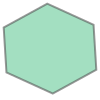

In [107]:
schools_deanon_100[0]['geometry']

In [108]:
# convert to dataframe
gdf = gpd.GeoDataFrame(schools_deanon_100, geometry='geometry',crs="EPSG:4326")

In [111]:
# combine with schools location on lat / lng columns
gdf = gdf.merge(school_locations, on=['lat','lng'])

In [112]:
gdf.head()

lat        lng  threshold_resolution           cell_set  \
0  30.988880 -97.366710                     8  [88489a1657fffff]   
1  29.957201 -95.436392                     8  [88446c350dfffff]   
2  30.879140 -97.401400                     8  [88489a8e85fffff]   
3  31.397236 -97.222274                     8  [88489a39cdfffff]   
4  33.508480 -94.615940                     8  [88444d2893fffff]   

                                            geometry  \
0  POLYGON ((-97.36621 30.99669, -97.37117 30.993...   
1  POLYGON ((-95.43174 29.95655, -95.43688 29.959...   
2  POLYGON ((-97.39499 30.8803, -97.39531 30.8854...   
3  POLYGON ((-97.22066 31.39317, -97.22097 31.398...   
4  POLYGON ((-94.61518 33.51762, -94.62024 33.515...   

                                     LongLabel         School_Nam  \
0  Little River, Little River-Academy, TX, USA      ACADEMY JJAEP   
1     11902 Spears Rd, Houston, TX, 77067, USA     FORTIS ACADEMY   
2                             Holland, TX, USA  BELL COUNTY JJAEP   
3   1191 Old Lorena Rd, Lorena, TX, 76655, USA         LORENA PRI   
4                             De Kalb, TX, USA    NEW BOSTON DAEP   

        County_Nam                  City        Subregion  
0      BELL COUNTY  Little River-Academy      Bell County  
1    HARRIS COUNTY               Houston    Harris County  
2      BELL COUNTY               Holland      Bell County  
3  MCLENNAN COUNTY                Lorena  McLennan County  
4     BOWIE COUNTY               De Kalb     Bowie County

In [113]:
# school_locations.to_csv("schools_anon_h3geometry.csv")
gdf.to_file('schools_anon_h3geometry.geojson', driver='GeoJSON')

ERROR 1: PROJ: proj_create_from_database: Open of /work/06562/lpearson/ls6/miniconda3/envs/geospatial/share/proj failed


## Select subset of data to map
The map can be slow to load with all 9000+ entries.  So we will select a subset by county, specifically the counties around Austin

In [88]:
austin_counties = ['Travis County','Willamson County', 'Hays County', 'Bastrop County']
austin_schools = school_locations[school_locations['Subregion'].isin(austin_counties)]

In [89]:
austin_schools.head()

lng        lat                                       LongLabel  \
59  -97.833076  30.143196       12120 Manchaca Rd, Austin, TX, 78748, USA   
69  -97.832417  30.457305  12200 Anderson Mill Rd, Austin, TX, 78726, USA   
107 -97.561461  30.357418     12900 Gregg Manor Rd, Manor, TX, 78653, USA   
117 -97.962117  29.884776      1300 Girard St, San Marcos, TX, 78666, USA   
125 -97.939300  29.859259         1301 TX-123, San Marcos, TX, 78666, USA   

                               School_Nam     County_Nam        City  \
59                            MENCHACA EL  TRAVIS COUNTY      Austin   
69   HARMONY SCIENCE ACADEMY - CEDAR PARK  TRAVIS COUNTY      Austin   
107                          MANOR MIDDLE  TRAVIS COUNTY       Manor   
117                           CROCKETT EL    HAYS COUNTY  San Marcos   
125                      GOODNIGHT MIDDLE    HAYS COUNTY  San Marcos   

         Subregion  threshold_resolution  \
59   Travis County                     8   
69   Travis County                     8   
107  Travis County                     7   
117    Hays County                     8   
125    Hays County                     8   

                                              cell_set  \
59                                   [88489eacc1fffff]   
69                                   [88489e2697fffff]   
107  [88489e21c1fffff, 88489e21c3fffff, 88489e21c5f...   
117                                  [88489eb467fffff]   
125                                  [88489eb735fffff]   

                                              geometry  
59   POLYGON ((-97.82961 30.14033, -97.82994 30.145...  
69   POLYGON ((-97.82948 30.45463, -97.82454 30.457...  
107  POLYGON ((-97.56365 30.37877, -97.56891 30.381...  
117  POLYGON ((-97.96109 29.88531, -97.96635 29.887...  
125  POLYGON ((-97.93871 29.85519, -97.93379 29.857...

In [90]:
austin_schools.Subregion.unique()

array(['Travis County', 'Hays County', 'Bastrop County'], dtype=object)

In [91]:
print(austin_schools.iloc[249]['geometry'])

POLYGON ((-97.72665305736709 30.288259622358417, -97.72171518417262 30.291006798939186, -97.72204301709841 30.296146343358586, -97.72730918683209 30.29853882501979, -97.73224738690362 30.295791562781965, -97.73191909036004 30.290651904556057, -97.72665305736709 30.288259622358417))


## Map with Folium

In [43]:
import folium
from folium.plugins import GroupedLayerControl

In [42]:
## Build folium base map
m = folium.Map(location=[30, -98], zoom_start=10)
# Add Resolutions
fg_resolutions = folium.FeatureGroup(name="resolutions")
m.add_child(fg_resolutions)

g6 = folium.plugins.FeatureGroupSubGroup(fg_resolutions, "Resolution 6")
m.add_child(g6)
g7 = folium.plugins.FeatureGroupSubGroup(fg_resolutions, "Resolution 7")
m.add_child(g7)
g8 = folium.plugins.FeatureGroupSubGroup(fg_resolutions, "Resolution 8")
m.add_child(g8)

# Add points
fg_points = folium.FeatureGroup(name="Schools")
m.add_child(fg_points)

In [27]:
for idx, row in austin_schools[austin_schools.threshold_resolution == 6].iterrows():
        folium.Polygon(
            locations=row['boundary_geometry'].outer,
            color='blue',
            weight=1,
            fill=False,
            fillColor='blue',
            fillOpacity=0.1,
            # opacity=0.8,
            # tooltip=tooltip_text
        ).add_to(g6)
for idx, row in austin_schools[austin_schools.threshold_resolution == 7].iterrows():
        folium.Polygon(
            locations=row['boundary_geometry'].outer,
            color='black',
            weight=1,
            fill=False,
            fillColor='blue',
            fillOpacity=0.1,
            # opacity=0.8,
            # tooltip=tooltip_text
        ).add_to(g7)    
for idx, row in austin_schools[austin_schools.threshold_resolution == 8].iterrows():
        folium.Polygon(
            locations=row['boundary_geometry'].outer,
            color='red',
            weight=1,
            fill=False,
            fillColor='blue',
            fillOpacity=0.1,
            # opacity=0.8,
            # tooltip=tooltip_text
        ).add_to(g8)    

In [28]:
# add actual school locations as dots on the map to assess the deidentification function 
for i in range(0,len(austin_schools)):
   folium.Circle(
      location=[austin_schools.iloc[i]['lat'], austin_schools.iloc[i]['lng']],
      popup=austin_schools.iloc[i]['School_Nam'],
      radius=10
   ).add_to(fg_points)

In [29]:
folium.LayerControl(collapsed=False).add_to(m)

In [30]:
m

In [25]:
m.save('schools_example_map.html')

In [ ]:
# for _, r in df.iterrows():
#     # Without simplifying the representation of each borough,
#     # the map might not be displayed
#     sim_geo = gpd.GeoSeries(r["geometry"]).simplify(tolerance=0.001)
#     geo_j = sim_geo.to_json()
#     geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {"fillColor": "orange"})
#     folium.Popup(r["BoroName"]).add_to(geo_j)
#     geo_j.add_to(m)

In [17]:
# Add H3 polygons
# Iterate through each row
for idx, row in austin_schools.iterrows():
    cells = row['cell_set']
    
    if not isinstance(cells, list) or len(cells) == 0:
        continue

    # Add each H3 cell
    for cell in cells:
        boundary = h3.cell_to_boundary(cell)
        polygon_coords = [[lat, lng] for lat, lng in boundary]
        
        folium.Polygon(
            locations=polygon_coords,
            color='red',
            weight=1,
            fill=False,
            fillColor='red',
            fillOpacity=0.1,
            # opacity=0.8,
            # tooltip=tooltip_text
        ).add_to(m)

In [19]:
# add actual school locations as dots on the map to assess the deidentification function 
for i in range(0,len(austin_schools)):
   folium.Circle(
      location=[austin_schools.iloc[i]['lat'], austin_schools.iloc[i]['lng']],
      popup=austin_schools.iloc[i]['School_Nam'],
      radius=10
   ).add_to(m)

In [20]:
# show map
m

In [21]:
pop.head()

h3  population
0  8848f6cc2dfffff           1
1  8848f6c9c9fffff           2
2  8848f6c9b9fffff           1
3  8848f6c92dfffff           1
4  8848f6c92bfffff           1